# Neural Network

In [260]:
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
from metrics.Multilabel_classification_metrics import Precision, Accuracy, Recall, F1Measure, Hamming_Loss

import pickle
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.linear_model import LogisticRegression
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import f1_score, accuracy_score
from sklearn.model_selection import RepeatedKFold
from keras.models import Sequential
from keras import layers, optimizers, losses
from keras.backend import clear_session
import keras_tuner as kt

## Load pickles objects

In [4]:
# Dataframe
path_df = "../Pickles/multilabel_binarizer.pickle"
with open(path_df, 'rb') as data:
    multilabel_binarizer = pickle.load(data)

# features_train
path_features_train = "../Pickles/features_train.pickle"
with open(path_features_train, 'rb') as data:
    features_train = pickle.load(data)

# labels_train
path_labels_train = "../Pickles/labels_train.pickle"
with open(path_labels_train, 'rb') as data:
    labels_train = pickle.load(data)

# features_test
path_features_test = "../Pickles/features_test.pickle"
with open(path_features_test, 'rb') as data:
    features_test = pickle.load(data)

# labels_test
path_labels_test = "../Pickles/labels_test.pickle"
with open(path_labels_test, 'rb') as data:
    labels_test = pickle.load(data)

In [18]:
# define the model
def get_model(n_inputs, n_outputs):
	model = Sequential()
	model.add(layers.Dense(20, input_dim=n_inputs, kernel_initializer='he_uniform', activation='relu'))
	model.add(layers.Dense(n_outputs, activation='sigmoid'))
	model.compile(loss='binary_crossentropy', optimizer='adam')
	return model

In [72]:
clear_session()
model = get_model(1000, 27)
history = model.fit(features_train, labels_train,
                     epochs=15,
                     verbose=True,
                     batch_size=10)

Epoch 1/15
857/857 [==============================] - 2s 2ms/step - loss: 0.2794
Epoch 2/15
857/857 [==============================] - 1s 2ms/step - loss: 0.2109
Epoch 3/15
857/857 [==============================] - 1s 2ms/step - loss: 0.1923
Epoch 4/15
857/857 [==============================] - 2s 2ms/step - loss: 0.1821
Epoch 5/15
857/857 [==============================] - 2s 2ms/step - loss: 0.1748
Epoch 6/15
857/857 [==============================] - 1s 2ms/step - loss: 0.1693
Epoch 7/15
857/857 [==============================] - 1s 2ms/step - loss: 0.1648
Epoch 8/15
857/857 [==============================] - 1s 2ms/step - loss: 0.1609
Epoch 9/15
857/857 [==============================] - 2s 2ms/step - loss: 0.1575
Epoch 10/15
857/857 [==============================] - 2s 2ms/step - loss: 0.1547
Epoch 11/15
857/857 [==============================] - 1s 2ms/step - loss: 0.1522
Epoch 12/15
857/857 [==============================] - 2s 2ms/step - loss: 0.1499
Epoch 13/15
857/857 [====

In [12]:
...
# make a prediction on the test set
yhat = model.predict(features_test)
# round probabilities to class labels
yhat = yhat.round()
yhat = yhat.astype(int)
# calculate accuracy
acc = accuracy_score(labels_test, yhat)

115/115 [==============================] - 0s 1ms/step


In [14]:
print(yhat[8])
print(labels_test[8])
print(acc)

[0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 1 1 0 0 0 0 0 0 0]
0.10726926218350122


In [ ]:
import keras.backend as K
from tensorflow.python.ops.numpy_ops import np_config
np_config.enable_numpy_behavior()

def get_f1(y_true, y_pred): #taken from old keras source code
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())
    f1_val = 2*(precision*recall)/(precision+recall+K.epsilon())

    return f1_val
def get_аccuracy(y_true, y_pred):
    temp = K.sum(K.round(K.clip(y_true * y_pred, 0, 1))) / K.sum(tf.where((K.equal(K.clip(y_true, 0, 1), K.clip(y_pred, 0, 1))), 0, 1))
    return 5

In [347]:
def model_builder(hp):

  clear_session()
  model = Sequential()
  hp_units = hp.Int('units', min_value=32, max_value=1024, step=32)
  model.add(layers.Dense(units=hp_units, input_dim=1000, kernel_initializer='he_uniform', activation='relu', name='dense_1'))
  model.add(layers.Dropout(0.3))
  model.add(layers.Dense(27, activation='sigmoid'))
  # Tune the learning rate for the optimizer
  # Choose an optimal value from 0.01, 0.001, or 0.0001
  hp_learning_rate = hp.Choice('learning_rate', values=[ 1e-2, 1e-3, 1e-4])
  model.compile(optimizer=optimizers.Adam(learning_rate=hp_learning_rate),
                loss=losses.BinaryCrossentropy(),
                metrics=[get_аccuracy])
  return model

In [348]:
import keras_tuner
tuner = kt.Hyperband(model_builder, # the hypermodel
                     objective=keras_tuner.Objective("val_get_аccuracy", direction="max"),
max_epochs=10,
factor=3)
# hypertuning settings
tuner.search_space_summary() 

INFO:tensorflow:Reloading Oracle from existing project .\untitled_project\oracle.json
INFO:tensorflow:Reloading Tuner from .\untitled_project\tuner0.json
Search space summary
Default search space size: 2
units (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 1024, 'step': 32, 'sampling': None}
learning_rate (Choice)
{'default': 0.01, 'conditions': [], 'values': [0.01, 0.001, 0.0001], 'ordered': True}


In [350]:
stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)
# Perform hypertuning
tuner.search(features_train, labels_train, epochs=10, validation_split=0.2, callbacks=[stop_early])

Trial 30 Complete [00h 00m 16s]
val_get_аccuracy: 0.008763905614614487

Best val_get_аccuracy So Far: nan
Total elapsed time: 00h 05m 36s
INFO:tensorflow:Oracle triggered exit


In [251]:
best_hp=tuner.get_best_hyperparameters()[0]

In [297]:
best_hp.values

{'units': 736,
 'learning_rate': 0.01,
 'tuner/epochs': 10,
 'tuner/initial_epoch': 4,
 'tuner/bracket': 1,
 'tuner/round': 1,
 'tuner/trial_id': '0022'}

In [298]:
h_model = tuner.hypermodel.build(best_hp)
h_model.summary()
h_model.fit(features_train, labels_train, epochs=10, validation_split=0.2)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_1 (Dense)             (None, 736)               736736    
                                                                 
 dropout (Dropout)           (None, 736)               0         
                                                                 
 dense (Dense)               (None, 27)                19899     
                                                                 
Total params: 756,635
Trainable params: 756,635
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
215/215 [==============================] - 2s 8ms/step - loss: 0.2040 - accuracy: 0.2682 - get_f1: 0.3488 - val_loss: 0.1799 - val_accuracy: 0.3104 - val_get_f1: 0.4921
Epoch 2/10
215/215 [==============================] - 2s 7ms/step - loss: 0.1571 - accuracy: 0.3750 - get_f1: 0.5258 - val_loss: 0.180

In [299]:
yhat = h_model.predict(features_test)
# round probabilities to class labels
print(yhat)

115/115 [==============================] - 0s 3ms/step
[[5.8118053e-07 5.6287036e-03 5.9970353e-07 ... 1.0341449e-08
  1.5575399e-05 1.1338976e-04]
 [3.6363285e-06 4.1961260e-02 5.2793190e-08 ... 7.2307889e-03
  1.1991366e-03 2.4305526e-05]
 [2.0567140e-04 2.0624622e-05 5.1120918e-05 ... 4.3716770e-02
  6.1602038e-01 9.9592054e-01]
 ...
 [1.7612297e-06 1.5862512e-06 9.2432829e-06 ... 1.9532758e-05
  2.5248507e-04 9.1320783e-01]
 [2.1747803e-05 2.0280933e-07 1.7929125e-11 ... 2.7457644e-11
  1.8110288e-11 1.1940379e-09]
 [1.8917372e-04 7.6019067e-05 1.4485509e-07 ... 1.0461893e-06
  1.1913580e-09 4.1069746e-01]]


In [300]:
t = 0.3 # threshold value
y_pred_new = (yhat >= t).astype(int)
print(y_pred_new[5])
print(labels_test[5])
# # calculate accuracy
acc = accuracy_score(labels_test, y_pred_new)

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 1 0 0 0 1 0 0 0 0 1 0 0 0 0 0 0 0 1 1 0]


In [301]:
print(yhat[8])
print(labels_test[8])
print(acc)

[1.47350727e-08 8.68962445e-07 1.32081880e-07 4.19184715e-07
 1.09973134e-05 7.54828751e-02 1.21037054e-04 4.74196719e-03
 2.74101285e-06 1.03551156e-06 1.00373570e-03 9.97187912e-01
 2.56042739e-07 1.32942328e-03 3.13591522e-06 1.61995308e-06
 2.01097250e-01 1.98437586e-08 2.70127156e-03 2.43710548e-01
 8.54338723e-05 4.16329249e-06 1.10403111e-03 1.06175911e-07
 5.02693772e-01 4.51238775e-05 5.96679002e-03]
[0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 1 1 0 0 0 0 0 0 0]
0.0999183228968146


In [302]:
# evaluate performance
F1Measure(labels_test, y_pred_new)

0.4348223984624788

In [303]:
# Exact Match Ratio:
accuracy_score(labels_test, y_pred_new)

0.0999183228968146

In [304]:
Accuracy(labels_test, y_pred_new)

0.348134175169297

In [305]:
Precision(labels_test, y_pred_new)

0.48586888880245827

In [306]:
Recall(labels_test, y_pred_new)

0.46467919048915535

In [365]:
multilabel_binarizer.classes_

array(['Adventure novel', 'Alternate history', 'Autobiography',
       'Biography', "Children's literature", 'Comedy', 'Comic novel',
       'Crime Fiction', 'Detective fiction', 'Dystopia', 'Fantasy',
       'Fiction', 'Gothic fiction', 'Historical fiction',
       'Historical novel', 'Horror', 'Mystery', 'Non-fiction', 'Novel',
       'Romance novel', 'Satire', 'Science Fiction',
       'Speculative fiction', 'Spy fiction', 'Suspense', 'Thriller',
       'Young adult literature'], dtype=object)

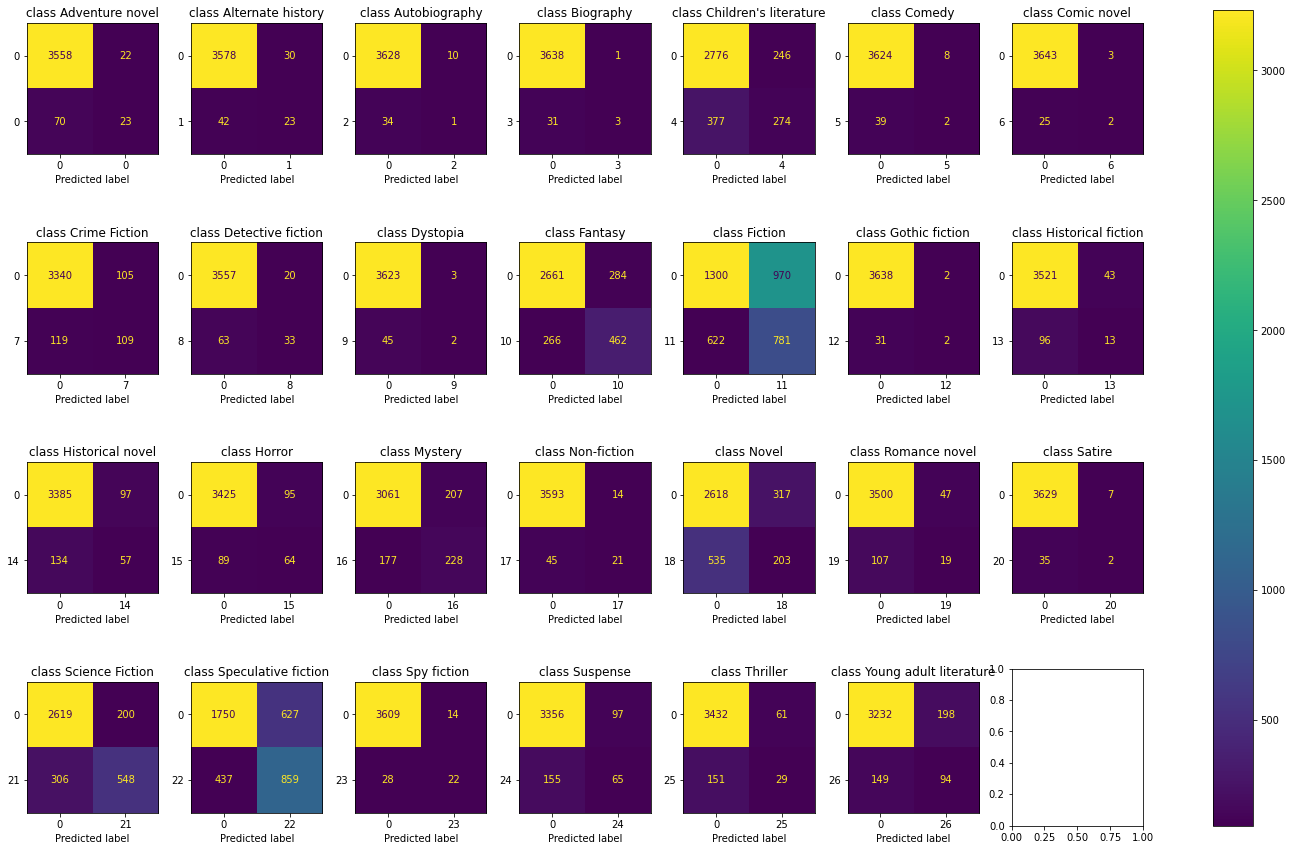

In [377]:

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
classes = multilabel_binarizer.classes_
f, axes = plt.subplots(4, 7, figsize=(25, 15))
axes = axes.ravel()
for i in range(27):
    disp = ConfusionMatrixDisplay(confusion_matrix(labels_test[:, i],
                                                   y_pred_new[:, i]),
                                  display_labels=[0, i])
    disp.plot(ax=axes[i], values_format='.4g')
    disp.ax_.set_title(f'class {classes[i]}')
    disp.ax_.set_ylabel('')
    disp.im_.colorbar.remove()

plt.subplots_adjust(wspace=0.25, hspace=0.4)
f.colorbar(disp.im_, ax=axes)
plt.show()